## Import

In [1]:
import cv2
import os, sys
import numpy as np
from collections import namedtuple
sys.path.append("C:/Users/asus/AppData/Local/Programs/Python/Python36/Lib/site-packages") # ของเฟยหงมันหาไม่เจอครับ
import pytesseract
import imutils
import collections
from matplotlib import pyplot as plt

pytesseract.pytesseract.tesseract_cmd = "C:/Program Files (x86)/Tesseract-OCR/tesseract" # ของเฟยหงมันหาไม่เจอครับ
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications import vgg16, vgg16_3layers

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

C:\Users\asus\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Crop frame picture

In [2]:
def crop_frame_picture(image):
    height, width,_ = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    blur = cv2.GaussianBlur(thresh, (5, 5), 0)
    edged = cv2.Canny(blur, 75, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            if((approx[2][0][0] - approx[0][0][0]) >= ((width/100)*60) and (approx[2][0][1] - approx[0][0][1]) >= ((height/100)*60)):
                x1 = approx[0][0][0] + 7
                y1 = approx[0][0][1] + 7
                x2 = approx[1][0][0] + 7
                y2 = approx[1][0][1] - 7
                x3 = approx[2][0][0] - 7
                y3 = approx[2][0][1] - 7
                x4 = approx[3][0][0] - 7
                y4 = approx[3][0][1] + 7
                screenCnt = np.array([[[x1, y1]], [[x2, y2]], [[x3, y3]], [[x4, y4]]])
                image = image[screenCnt[0][0][1]:screenCnt[2][0][1], screenCnt[0][0][0]:screenCnt[2][0][0]]
                return image
            else:
                return image
        else:
            return image

## Data repeatly

In [3]:
def repeatly(data):
    c = collections.Counter(data)
    c = c.most_common(3)
    #print(c)
    c_max = c[0]
    c_max_data = c[0][1]
    for i in range(len(c)):
        if (c_max_data < c[i][1]):
            c_max = c[i]
            c_max_data = c[i][1]
    return c_max[0]

## Tesseract segmentation

In [4]:
def tesseract_seg(image,array = np.array([])):
    h, w, _ = image.shape
    boxes = pytesseract.image_to_boxes(image, lang='tha')
    num_count = 0
    x_d = []
    y_d = []
    w_d = []
    h_d = []
    for b in boxes.splitlines():
        b = b.split(' ')
        xmin = int(b[1])
        ymax = h - int(b[2])
        xmax = int(b[3])
        ymin = h - int(b[4])
        x_d.append(xmin)
        y_d.append(ymin)
        w_d.append(xmax - xmin)
        h_d.append(ymax - ymin)
        num_count += 1
    if(len(w_d) >= 3 and len(h_d) >= 3):
        m_w, m_h = repeatly(w_d), repeatly(h_d)
        for i in range(num_count):
            data = x_d[i],y_d[i], x_d[i]+w_d[i], y_d[i] + h_d[i]
            if (((x_d[i] + w_d[i]) - x_d[i]) <= (m_w * 3) and ((y_d[i] + h_d[i]) - y_d[i]) <= (m_h * 1.4)):
                if len(array)  == 0:
                    array = np.array([data])
                else:
                    sub = np.array(data)
                    array = np.vstack((sub, array))
    else:
        for i in range(num_count):
            data = x_d[i],y_d[i], x_d[i]+w_d[i], y_d[i] + h_d[i]
            if len(array) == 0:
                array = np.array([data])
            else:
                sub = np.array(data)
                array = np.vstack((sub, array))
    return array

## Ocr find contour segmentation

In [5]:
def ocr_findcontour(image,array = np.array([])):
    gray_each = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret2, thresh_each = cv2.threshold(gray_each, 127, 255, cv2.THRESH_BINARY_INV)
    im2, ctrs2, hier2 = cv2.findContours(thresh_each.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_count = 0
    x_d = []
    y_d = []
    w_d = []
    h_d = []
    for j, c in enumerate(ctrs2):
        x, y, w, h = cv2.boundingRect(c)
        x_d.append(x)
        y_d.append(y)
        w_d.append(w)
        h_d.append(h)
        num_count += 1
    if (len(w_d) >= 3 and len(h_d) >= 3):
        m_w, m_h = repeatly(w_d), repeatly(h_d)
        for i in range(num_count):
            data = x_d[i],y_d[i], x_d[i]+w_d[i], y_d[i] + h_d[i]
            if (((x_d[i]+w_d[i]) - x_d[i]) <= (m_w * 5) and ((y_d[i] + h_d[i]) - y_d[i]) <= (m_h * 2)):
                if len(array)  == 0:
                    array = np.array([data])
                else:
                    sub = np.array(data)
                    array = np.vstack((sub, array))
    else:
        for i in range(num_count):
            data = x_d[i],y_d[i], x_d[i]+w_d[i], y_d[i] + h_d[i]
            if len(array) == 0:
                array = np.array([data])
            else:
                sub = np.array(data)
                array = np.vstack((sub, array))
    return array

## Ocr mser segmentation

In [6]:
def area_mser(a, b):
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx >= 0) and (dy >= 0):
        return None
    else:
        return b.xmin,b.ymin,b.xmax,b.ymax

def mean_mser(data):
    count = 1
    all_data = 0
    for i in data:
        all_data += i
        count += 1
    avr = all_data/count
    return  avr

def ocr_mser(image,array = np.array([])):
    Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')
    mser = cv2.MSER_create()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    regions = mser.detectRegions(gray)
    hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions[0]]
    num_count = 0
    x_d = []
    y_d = []
    w_d = []
    h_d = []
    for i, c in enumerate(hulls):
        x, y, w, h = cv2.boundingRect(c)
        x_d.append(x)
        y_d.append(y)
        w_d.append(w)
        h_d.append(h)
        num_count += 1
    if (len(w_d) >= 3 and len(h_d) >= 3):
        m_w, m_h = repeatly(w_d), repeatly(h_d)
        mean_w, mean_h = mean_mser(w_d),mean_mser(h_d)
        for i in range(num_count):
            if(len(hulls) > 1):
                if i > 1:
                    a = Rectangle(x_d[i - 1], y_d[i - 1], x_d[i - 1] + w_d[i - 1], y_d[i - 1] + h_d[i - 1])
                    b = Rectangle(x_d[i], y_d[i], x_d[i] + w_d[i], y_d[i] + h_d[i])
                    if area_mser(a, b) != None:
                        x, y, xm, ym = area_mser(a, b)
                        if ((xm - x) <= (mean_w * 0.2) and (ym - y) <= (m_h * 2)):
                            data = x, y, xm, ym
                            if len(array) == 0:
                                array = np.array([data])
                            else:
                                sub = np.array(data)
                                array = np.vstack((sub, array))
            else:
                data = x_d[i], y_d[i], x_d[i] + w_d[i], y_d[i] + h_d[i]
                array = np.array([data])
    else:
        for i in range(num_count):
            if(len(hulls) > 1):
                if i > 1:
                    a = Rectangle(x_d[i - 1], y_d[i - 1], x_d[i - 1] + w_d[i - 1], y_d[i - 1] + h_d[i - 1])
                    b = Rectangle(x_d[i], y_d[i], x_d[i] + w_d[i], y_d[i] + h_d[i])
                    if area_mser(a, b) != None:
                        x, y, xm, ym = area_mser(a, b)
                        data = x, y, xm, ym
                        if len(array) == 0:
                            array = np.array([data])
                        else:
                            sub = np.array(data)
                            array = np.vstack((sub, array))
            else:
                data = x_d[i], y_d[i], x_d[i] + w_d[i], y_d[i] + h_d[i]
                array = np.array([data])

    return  array

## Non max suppression slow

In [7]:
def non_max_suppression_slow(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            overlap = float(w * h) / area[j]

            if overlap > overlapThresh:
                suppress.append(pos)
        idxs = np.delete(idxs, suppress)
    return boxes[pick]

## Get data from list

In [8]:
def get_data_list_xmin(data):
    return data[0]

def get_data_list_ymin(data):
    return data[1]

## Character segmentation

In [9]:
def cha_segment(image, verbose = False):
    image = crop_frame_picture(image)

    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV)

    #dilation (make line)
    kernel = np.ones((15,120), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)

    im,ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

    image_list = []
    data_space = []
    row_bnd_list = []
    for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        data_space.append((x,y,w+x,h+y))
    new_data_space = sorted(data_space, key= get_data_list_ymin)
    for i in range(len(new_data_space)):
        if i < (len(new_data_space)-1):
            if new_data_space[i][1] == new_data_space[i+1][1]:
                if new_data_space[i][0] <= new_data_space[i+1][0]:
                    x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2],new_data_space[i][3]
                    roi = image[y:ymax, x:xmax]
                    image_list.append(roi)
                    row_bnd_list.append((x,y,xmax,ymax))
                else:
                    keep_data = new_data_space[i]
                    new_data_space[i] = new_data_space[i+1]
                    new_data_space[i+1] = keep_data
                    x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2],new_data_space[i][3]
                    roi = image[y:ymax, x:xmax]
                    image_list.append(roi)
                    row_bnd_list.append((x, y, xmax, ymax))
            else:
                x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2], new_data_space[i][3]
                roi = image[y:ymax, x:xmax]
                image_list.append(roi)
                row_bnd_list.append((x, y, xmax, ymax))

        else:
            x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2], new_data_space[i][3]
            roi = image[y:ymax, x:xmax]
            image_list.append(roi)
            row_bnd_list.append((x, y, xmax, ymax))

    lst_bnd = []
    for img in image_list:
        bnd = tesseract_seg(img)
        bnd = ocr_findcontour(img,bnd)
        #bnd = ocr_findcontour(img)
        bnd = ocr_mser(img,bnd)
        #bnd = ocr_mser(img)
        img_bnd = [(img, bnd)]
        for (imagePath, boundingBoxes) in img_bnd:
            sub_bnd = []
            print("[x] %d initial bounding boxes" % (len(boundingBoxes)))
            image_nms = imagePath
            orig = image.copy()
            pick = non_max_suppression_slow(boundingBoxes, 0.3)
            new_pick = np.array([])
            new_data_space = sorted(pick, key=get_data_list_xmin)
            for i in range(len(new_data_space)):
                if i < (len(new_data_space) - 2):
                    if new_data_space[i][2] - new_data_space[i+1][0] < (((new_data_space[i][2] - new_data_space[i][0])/100)*35) and new_data_space[i][2] - new_data_space[i+1][0] > 1 and new_data_space[i+1][2] != new_data_space[i][2]:
                        if new_data_space[i+1][1] < new_data_space[i][1]:
                            if new_data_space[i+1][1] < new_data_space[i+2][1]:
                                keep_data = new_data_space[i + 1]
                                new_data_space[i + 1] = new_data_space[i + 2]
                                new_data_space[i + 2] = keep_data
                                x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2], \
                                                   new_data_space[i][3]
                            else:
                                x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2], new_data_space[i][3]
                        else:
                            x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2], \
                                               new_data_space[i][3]
                    elif new_data_space[i][0] == new_data_space[i+1][0]:
                        if(new_data_space[i][1] >= new_data_space[i+1][1]):
                            x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2], \
                                               new_data_space[i][3]
                        else:
                            keep_data = new_data_space[i]
                            new_data_space[i] = new_data_space[i + 1]
                            new_data_space[i + 1] = keep_data
                            x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2], \
                                               new_data_space[i][3]
                    else:
                        x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2], \
                                           new_data_space[i][3]
                    if len(new_pick) == 0:
                        new_pick = np.array([(x, y, xmax, ymax)])
                    else:
                        sub = np.array((x, y, xmax, ymax))
                        new_pick = np.vstack((new_pick, sub))
                elif i == (len(new_data_space) - 2):
                    if new_data_space[i][2] - new_data_space[i + 1][0] < (
                        ((new_data_space[i][2] - new_data_space[i][0]) / 100) * 35) and new_data_space[i][2] - \
                            new_data_space[i + 1][0] > 1 and new_data_space[i + 1][2] != new_data_space[i][2]:
                        if new_data_space[i][1] >= new_data_space[i+1][1]:
                            x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2], \
                                               new_data_space[i][3]
                        else:
                            keep_data = new_data_space[i]
                            new_data_space[i] = new_data_space[i + 1]
                            new_data_space[i + 1] = keep_data
                            x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2], \
                                               new_data_space[i][3]
                    else:
                        x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2], \
                                           new_data_space[i][3]
                    if len(new_pick) == 0:
                        new_pick = np.array([(x, y, xmax, ymax)])
                    else:
                        sub = np.array((x, y, xmax, ymax))
                        new_pick = np.vstack((new_pick, sub))
                else:
                    x, y, xmax, ymax = new_data_space[i][0], new_data_space[i][1], new_data_space[i][2], \
                                       new_data_space[i][3]
                    if len(new_pick) == 0:
                        new_pick = np.array([(x, y, xmax, ymax)])
                    else:
                        sub = np.array((x, y, xmax, ymax))
                        new_pick = np.vstack((new_pick, sub))
            print("[x] after applying non-maximum, %d bounding boxes" % (len(new_pick)))


            for (startX, startY, endX, endY) in new_pick:
                data = startX, startY, endX, endY
                sub_bnd.append(data)
                if verbose == True:
                    cv2.rectangle(image_nms, (startX, startY), (endX, endY), (255, 100, 0), 2)
            lst_bnd.append(sub_bnd)
    return lst_bnd, image_list, row_bnd_list

## Test image segmentation

[x] 64 initial bounding boxes
[x] after applying non-maximum, 39 bounding boxes
[x] 20 initial bounding boxes
[x] after applying non-maximum, 11 bounding boxes
[x] 57 initial bounding boxes
[x] after applying non-maximum, 33 bounding boxes
[x] 0 initial bounding boxes
[x] after applying non-maximum, 0 bounding boxes
[x] 29 initial bounding boxes
[x] after applying non-maximum, 16 bounding boxes


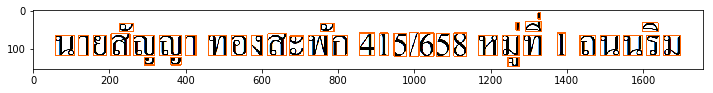

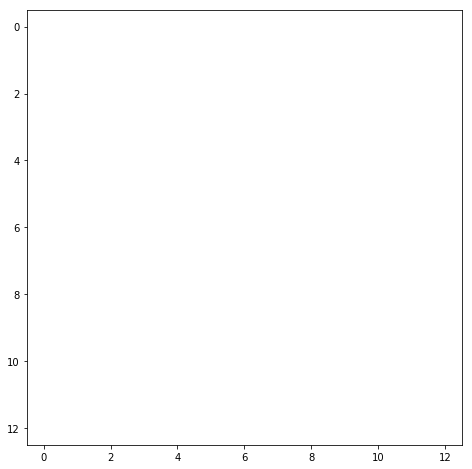

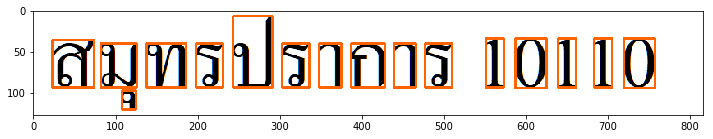

In [10]:
path_image = "real_world_image/demo_letter1.png"
image = cv2.imread(path_image)
IMAGE_SIZE = (12, 8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image)
data_list,img_list,row_bnd = cha_segment(image,True)
for i in range(len(img_list)):
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(img_list[i])

[x] 43 initial bounding boxes
[x] after applying non-maximum, 19 bounding boxes
[x] 3 initial bounding boxes
[x] after applying non-maximum, 3 bounding boxes
[x] 30 initial bounding boxes
[x] after applying non-maximum, 19 bounding boxes
[x] 57 initial bounding boxes
[x] after applying non-maximum, 32 bounding boxes
[x] 47 initial bounding boxes
[x] after applying non-maximum, 25 bounding boxes
[x] 32 initial bounding boxes
[x] after applying non-maximum, 18 bounding boxes
[x] 10 initial bounding boxes
[x] after applying non-maximum, 5 bounding boxes
[x] 16 initial bounding boxes
[x] after applying non-maximum, 12 bounding boxes


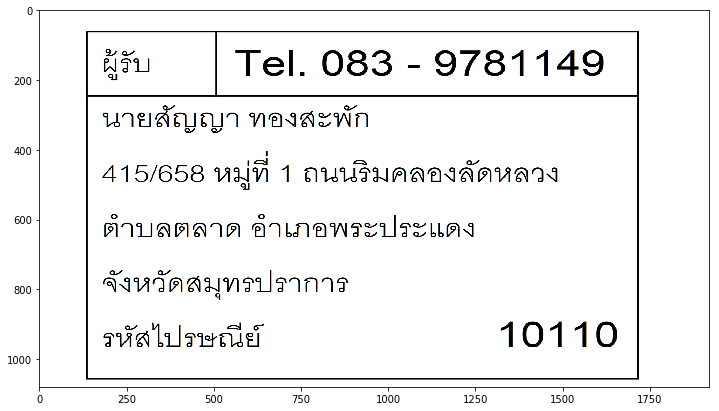

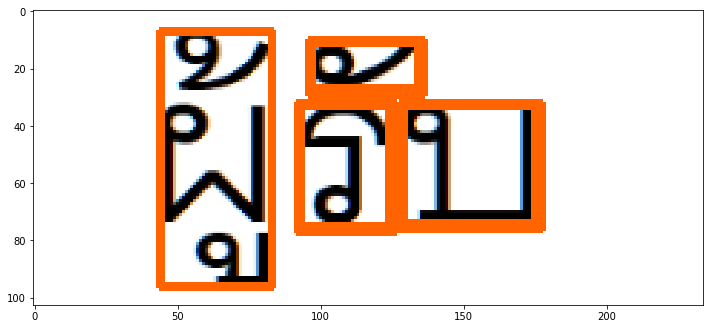

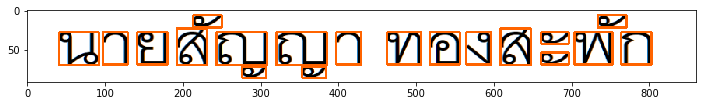

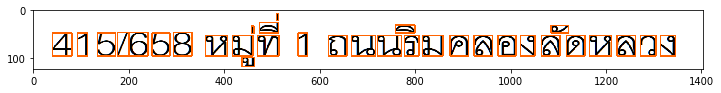

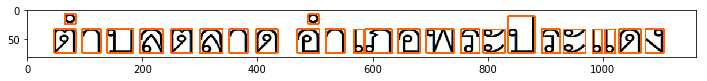

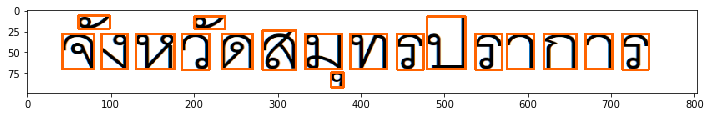

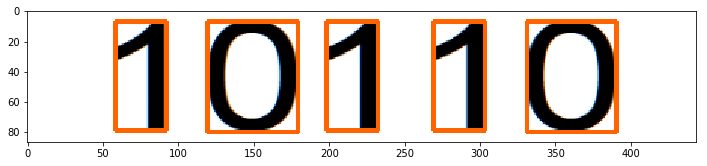

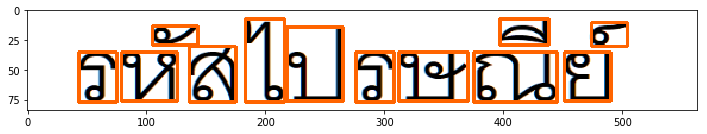

In [11]:
path_image = "real_world_image/demo_letter2.png"
image = cv2.imread(path_image)
IMAGE_SIZE = (12, 8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image)
data_list,img_list,row_bnd = cha_segment(image,True)
for i in range(len(img_list)):
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(img_list[i])

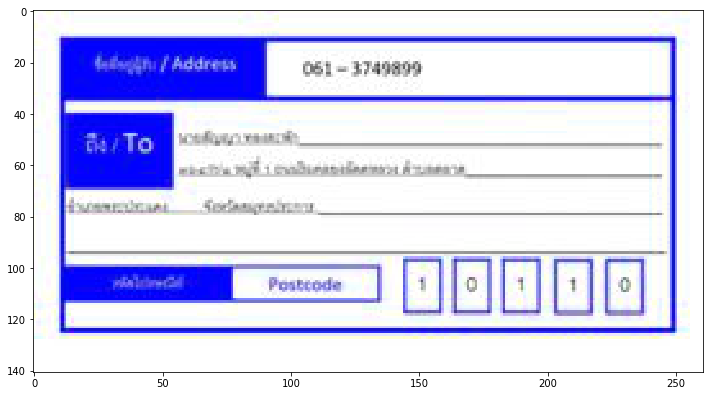

In [12]:
path_image = "real_world_image/o3.jpg"
image = cv2.imread(path_image)
IMAGE_SIZE = (12, 8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image)
data_list,img_list,row_bnd = cha_segment(image,True)
for i in range(len(img_list)):
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(img_list[i])

## Intergizer model setup and load weight.

In [13]:
intergizer_model = Sequential()
layers = vgg16_3layers.VGG16_3Layers(weights=None, input_shape=(160, 160, 3), pooling='max')
for layer in layers.layers[:-1]:
    intergizer_model.add(layer)
intergizer_model.add(Dense(2, activation='softmax'))
intergizer_model.load_weights("intergizer.hdf5")

## Integer detector model setup and load weight.

In [14]:
shape = (64, 64, 3)
code = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "\\", "/", "-"]
intdetector_model = Sequential()
vgg16_model = vgg16.VGG16(include_top=False, input_shape=shape)  # For train in customize input shape
for layer in vgg16_model.layers[:-1]:
    intdetector_model.add(layer)
intdetector_model.add(Flatten(name='flatten'))  # For train in customize input shape
intdetector_model.add(Dense(4096, activation='relu', name='fc1'))  # For train in customize input shape
intdetector_model.add(Dense(4096, activation='relu', name='fc2'))  # For train in customize input shape
intdetector_model.add(Dense(13, activation="softmax"))
intdetector_model.load_weights("intdetector.hdf5")

In [15]:
result_text = ""
image = cv2.imread("real_world_image/demo_letter1.png")

data_list, img_list, row_bnd = cha_segment(image, False)

[x] 64 initial bounding boxes
[x] after applying non-maximum, 39 bounding boxes
[x] 20 initial bounding boxes
[x] after applying non-maximum, 11 bounding boxes
[x] 57 initial bounding boxes
[x] after applying non-maximum, 33 bounding boxes
[x] 0 initial bounding boxes
[x] after applying non-maximum, 0 bounding boxes
[x] 29 initial bounding boxes
[x] after applying non-maximum, 16 bounding boxes


In [16]:
image_num = 0
index_list = []
row = []
for sub_img in img_list:
    coordinate = []
    index = 0
    for locate in data_list[image_num]:
        y, ymax, x, xmax = locate[1], locate[3], locate[0], locate[2]
        crop = sub_img[y: ymax, x: xmax]
        resized = cv2.resize(crop, (160, 160))
        resized = cv2.blur(resized, (8, 8))
        img = np.expand_dims(resized, axis=0)
        intergize_cls = intergizer_model.predict_classes(img)
        if intergize_cls[0] == 0:
            resized = cv2.resize(crop, (64, 64))
            img = np.expand_dims(resized, axis=0)
            cls = intdetector_model.predict_classes(img)
            conf = intdetector_model.predict(img)
            if code[cls[0]] == '9' or code[cls[0]] == '-':
                if conf.tolist()[0][cls[0]]*100 > 99:
                    result_text += code[cls[0]]
                if image_num not in row:
                    row.append(image_num)
                coordinate.append(index)
            elif conf.tolist()[0][cls[0]]*100 > 99.9:
                result_text += (code[cls[0]])
                if image_num not in row:
                    row.append(image_num)
                coordinate.append(index)
            index += 1
    if coordinate:
        index_list.append(coordinate)
    result_text += "\n"
    image_num += 1

words = []
for seg in result_text.replace("\n", " ").split(" "):
    if seg != '':
        words.append([seg])
print(words, row)

[['415/65811'], ['0011'], ['11110110']] [0, 2, 4]


## L'adresse system

In [17]:
def all_number_set(word_list,row_list,index_list,bnd_list,row_bnd_list):
    dic = {}
    num_list = []
    word_all = ''
    old_index = 0
    bnd = []
    check = False
    max_row = len(row_list)
    for i,row in enumerate(row_list):
        data_count = 0
        order = 1
        for word in word_list[i]:
            for e_w in word:
                data_count += 1
        for word in word_list[i]:
            count = 0
            for e_w in word:
                if(check == False):
                    word_all += e_w
                    bnd.append(bnd_list[row][index_list[i][count]])
                    old_index = bnd_list[row][index_list[i][count]]
                    check = True
                elif old_index == bnd_list[row][index_list[i][count]-1]:
                    word_all += e_w
                    old_index = bnd_list[row][index_list[i][count]]
                    bnd.append(bnd_list[row][index_list[i][count]])
                elif old_index != bnd_list[row][index_list[i][count]-1]:
                    xmin,ymin,xmax,ymax = float("inf"),float("inf"),0,0
                    for data in bnd:
                        if xmin >= data[0]:
                            xmin = data[0]
                        if xmax <= data[2]:
                            xmax = data[2]
                        if ymin >= data[1]:
                            ymin = data[1]
                        if ymax <= data[3]:
                            ymax = data[3]
                    cg_x = ((xmax + xmin)/2) + row_bnd_list[row][0]
                    cg_y = ((ymax + ymin)/2) + row_bnd_list[row][1]
                    dic['content'] = word_all
                    dic['row'] = row + 1
                    dic['position'] = (cg_x, cg_y)
                    dic['order'] = order
                    dic['max_row'] = max_row
                    num_list.append(dic.copy())
                    order += 1
                    word_all = ''
                    bnd = []
                    check = False
                    old_index = bnd_list[row][index_list[i][count]]
                    word_all += e_w
                    bnd.append(bnd_list[row][index_list[i][count]])
                if count == data_count - 1:
                    xmin, ymin, xmax, ymax = float("inf"), float("inf"), 0, 0
                    for data in bnd:
                        if xmin >= data[0]:
                            xmin = data[0]
                        if xmax <= data[2]:
                            xmax = data[2]
                        if ymin >= data[1]:
                            ymin = data[1]
                        if ymax <= data[3]:
                            ymax = data[3]
                    cg_x = ((xmax + xmin) / 2) + row_bnd_list[row][0]
                    cg_y = ((ymax + ymin) / 2) + row_bnd_list[row][1]
                    dic['content'] = word_all
                    dic['row'] = row + 1
                    dic['position'] = (cg_x, cg_y)
                    dic['order'] = order
                    dic['max_row'] = max_row
                    num_list.append(dic.copy())
                    word_all = ''
                    bnd = []
                    check = False
                count += 1
    return num_list

In [18]:
class Number_in_Address:
    def __init__(self, input_dict=None, input_list=None):
        self.number = input_dict['content']
        self.row = input_dict['row']
        self.pos = input_dict['position']
        self.distance = None
        self.score = 0
        self.order = input_dict['order']
        self.confidence = 0
        self.len_number = len(self.number)
        self.max_order = len(input_list)
        self.max_row = input_dict['max_row']

    def add_weight(self, slash_w=20, row_w=10, pos_w=10, order_w=10, len_w=20):
        self.slash_w = slash_w
        self.row_w = row_w
        self.pos_w = pos_w
        self.order_w = order_w
        self.len_w = len_w
        self.max_w = self.slash_w + self.row_w + self.pos_w + self.order_w + self.len_w

    def compute(self):
        if '/' in self.number:
            self.score += self.slash_w
        self.score += self.row_w - (self.row * 1)
        self.score += self.order_w - (self.order * 1)
        self.score += self.len_w - (abs(self.len_number - 6.5) * 2)

    def return_score(self):
        return (self.score / self.max_w) * 10


def get_Address(input, debug=0):
    Numbers_in_Address = []
    for i in input:
        Numbers_in_Address.append(Number_in_Address(input_list=input, input_dict=i))

        if debug == 1: print(i)

    for content in Numbers_in_Address:
        content.add_weight()
        content.compute()
        if debug == 1: print("Number is {} and Score is {}".format(content.number, content.return_score()))

    return max(Numbers_in_Address, key=lambda x: x.score).number


## Test L'adresse system

In [19]:
all_address = all_number_set(words, row, index_list, data_list, row_bnd)
print(get_Address(all_address, 1))

{'content': '415/658', 'row': 1, 'position': (436.0, 201.5), 'order': 1, 'max_row': 3}
{'content': '11', 'row': 1, 'position': (727.0, 174.5), 'order': 2, 'max_row': 3}
{'content': '00', 'row': 3, 'position': (123.5, 580.5), 'order': 1, 'max_row': 3}
{'content': '11', 'row': 3, 'position': (251.0, 580.5), 'order': 2, 'max_row': 3}
{'content': '11110110', 'row': 5, 'position': (255.0, 766.5), 'order': 1, 'max_row': 3}
Number is 415/658 and Score is 8.142857142857142
Number is 11 and Score is 4.0
Number is 00 and Score is 3.857142857142857
Number is 11 and Score is 3.7142857142857144
Number is 11110110 and Score is 4.428571428571429
415/658
